In [103]:
%load_ext autoreload
%autoreload 2
from NewtonOptimizer import NewtonOptimizer
import sys
sys.path.append('/Users/lindseyschweitzer/Documents/GitHub/lfschweitzer.github.io/')

from posts.post5.logistic import LogisticRegression, GradientDescentOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# <u> Newton’s Method for Logistic Regression <u>

Blog post includes implementing Newton's Method for Logistic Regression and performing 3 experiments.


These three experiments include:
1. When alpha is chosen appropriately, Newton’s method converges to the correct choice of w.
2. Under at least some circumstances, Newton’s method can converge much faster than standard gradient descent, in the sense of decreasing the empirical risk.
3. If alpha is too large, Newton’s method fails to converge.

## Data Generation

Before doing any experiments, I had to generate data for a classification problem.

In [104]:
import torch

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

Plot the data

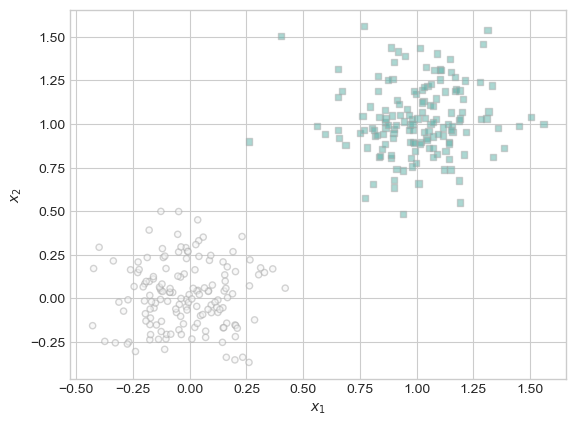

In [105]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def plot_classification_data(X, y, ax):
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
    
    
fig, ax = plt.subplots(1, 1)

# p_dims is 2
X, y = classification_data(noise = 0.2)
plot_classification_data(X, y, ax)

Code to graph a straight line

In [106]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

## 1. When alpha is chosen appropriately, Newton’s method converges to the correct choice of w.

In [107]:
# initialize a Logistic Regression 
LR = LogisticRegression() 
opt = NewtonOptimizer(LR)

# initialize for main loop
loss_vec_van = []

for index in range(5000):
    
    opt.step(X, y, alpha = 0.3)
    
    loss = LR.loss(X, y).item()
    loss_vec_van.append(loss)

In [108]:
def find_accuracy(X, y):

    predictions = LR.predict(X)
    correct_preds = (predictions == y).float()
    accuracy = torch.mean(correct_preds)

    print(f"Accuracy: {accuracy.item()}")

find_accuracy(X, y)

Accuracy: 1.0


Plot the loss over time over the 2000 iterations.

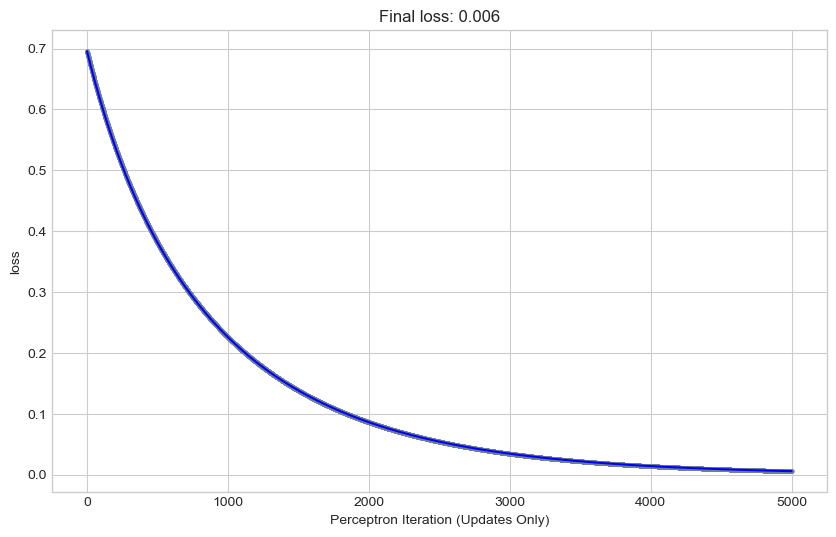

In [109]:
import numpy as np

def plot_loss(loss, label= ""):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))

    
    plt.plot(loss, color = "blue", label=label)
    plt.scatter(torch.arange(len(loss)), loss, color = "slategrey", s=5)
    plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
    
    plt.title(f"Final loss: {loss[len(loss)-1]:.3f}")

plot_loss(loss_vec_van)

## 2. Under at least some circumstances, Newton’s method can converge much faster than standard gradient descent, in the sense of decreasing the empirical risk.

First lets do standard gradient descent so we can compare it to Newton's method later.

In [125]:
X, y = classification_data(noise = 3)

LR_Stand = LogisticRegression() 
opt = GradientDescentOptimizer(LR_Stand)

# initialize for main loop
loss_vec_stand = []

for index in range(5000):
    
    # for vanilla gradient descent, alpha must be sufficiently small and beta must be 0
    opt.step(X, y, alpha = 0.2, beta = 0)
    loss = LR_Stand.loss(X, y).item()
    loss_vec_stand.append(loss)

In [122]:
find_accuracy(X, y)

Accuracy: 0.5733333230018616


Now, lets show do Newton's method to compare the decrease in empirical risk.

In [126]:
# Use the same data as before

# initialize a Logistic Regression and use Newton Optimizer
LR_Newt = LogisticRegression() 
opt = NewtonOptimizer(LR_Newt)

loss_vec_newt = []

for index in range(5000):
    
    opt.step(X, y, alpha = 0.2)
    
    loss = LR_Newt.loss(X, y).item()
    loss_vec_newt.append(loss)

In [113]:
find_accuracy(X, y)

Accuracy: 0.5899999737739563


Now let's compare the decrease in empirical risk:

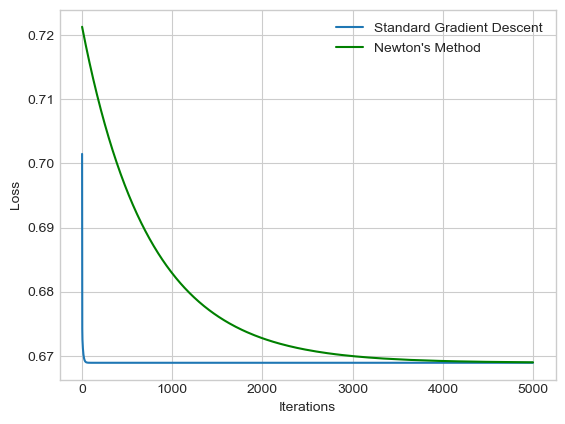

In [127]:
plt.plot(loss_vec_stand, label='Standard Gradient Descent')
plt.plot(loss_vec_newt, color='green', label="Newton's Method")

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

## 3. If alpha is too large, Newton’s method fails to converge.